# Data preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random

## Data division

In [4]:
with open("utils/train_test_division.json") as f:
    species_date_count = json.load(f)

In [ ]:
# get date count by species
# target = 'E:/Giacomo/Tovanella/orig_segments/train'
# species_date_count = {}
# for specie in os.listdir(target):
#     if target not in species_date_count:
#         species_date_count[specie] = {}
#     audio_names = os.listdir(os.path.join(target, specie))
#     date_counts = { audio.split("_")[0]: 0 for audio in audio_names }
#     for date in date_counts:
#         species_date_count[specie][date] = { "count": sum(date in audio for audio in audio_names), "is_training": False}
# species_date_count

{'Certhia familiaris_Eurasian Treecreeper': {'20190603': {'count': 16,
   'is_training': False},
  '20190608': {'count': 5, 'is_training': False},
  '20190621': {'count': 21, 'is_training': False},
  '20200215': {'count': 1, 'is_training': False},
  '20200217': {'count': 3, 'is_training': False}},
 'Dendrocopos major_Great Spotted Woodpecker': {'20200215': {'count': 12,
   'is_training': False},
  '20200217': {'count': 9, 'is_training': False}},
 'Dryocopus martius_Black Woodpecker': {'20190608': {'count': 24,
   'is_training': False},
  '20200215': {'count': 1, 'is_training': False},
  '20200217': {'count': 10, 'is_training': False}},
 'Erithacus rubecula_European Robin': {'20190603': {'count': 1,
   'is_training': False},
  '20190608': {'count': 410, 'is_training': False},
  '20190621': {'count': 23, 'is_training': False}},
 'Fringilla coelebs_Common Chaffinch': {'20190603': {'count': 1006,
   'is_training': False},
  '20190608': {'count': 740, 'is_training': False},
  '20190621': {'

In [ ]:
# come dividere tra train e test?
# se c'è una data sola -> ignora
# se ce ne sono solo 2 -> minore -> test, maggiore -> train
# se ce ne sono piu di 2 -> 
#           prendi la maggiore e somma il count totale delle altre
#               se > della metà della maggioranza,
#                   togli dalla minoranza l'elemento maggiore
#                   ripeti
#               altrimenti: a posto
# 
for specie in species_date_count.keys():
    dates = list(species_date_count[specie].keys())
    date_count = len(dates)
    values = [ value["count"] for value in species_date_count[specie].values() ]
    if date_count <= 1:
        species_date_count[specie][dates[0]]["to_remove"] = True
        continue
    elif date_count == 2:
        greatest_date = dates[np.argmax(values)]
        species_date_count[specie][greatest_date]["is_training"] = True
    else:
        greatest_value_index = np.argmax(values)
        greatest_value_date = dates[greatest_value_index]
        greatest_value = species_date_count[specie][greatest_value_date]["count"]
        species_date_count[specie][greatest_value_date]["is_training"] = True
        
        other_values = [ value["count"] if value["is_training"] == False else 0 for value in species_date_count[specie].values() ]
        sum_other_values = sum(other_values)
        while sum_other_values > greatest_value / 2:
            greatest_value_index = np.argmax(other_values)
            greatest_value_date = dates[greatest_value_index]
            species_date_count[specie][greatest_value_date]["is_training"] = True
            sum_other_values -= species_date_count[specie][greatest_value_date]["count"]

In [ ]:
species_date_count["Pyrrhula pyrrhula_Eurasian Bullfinch"]

1

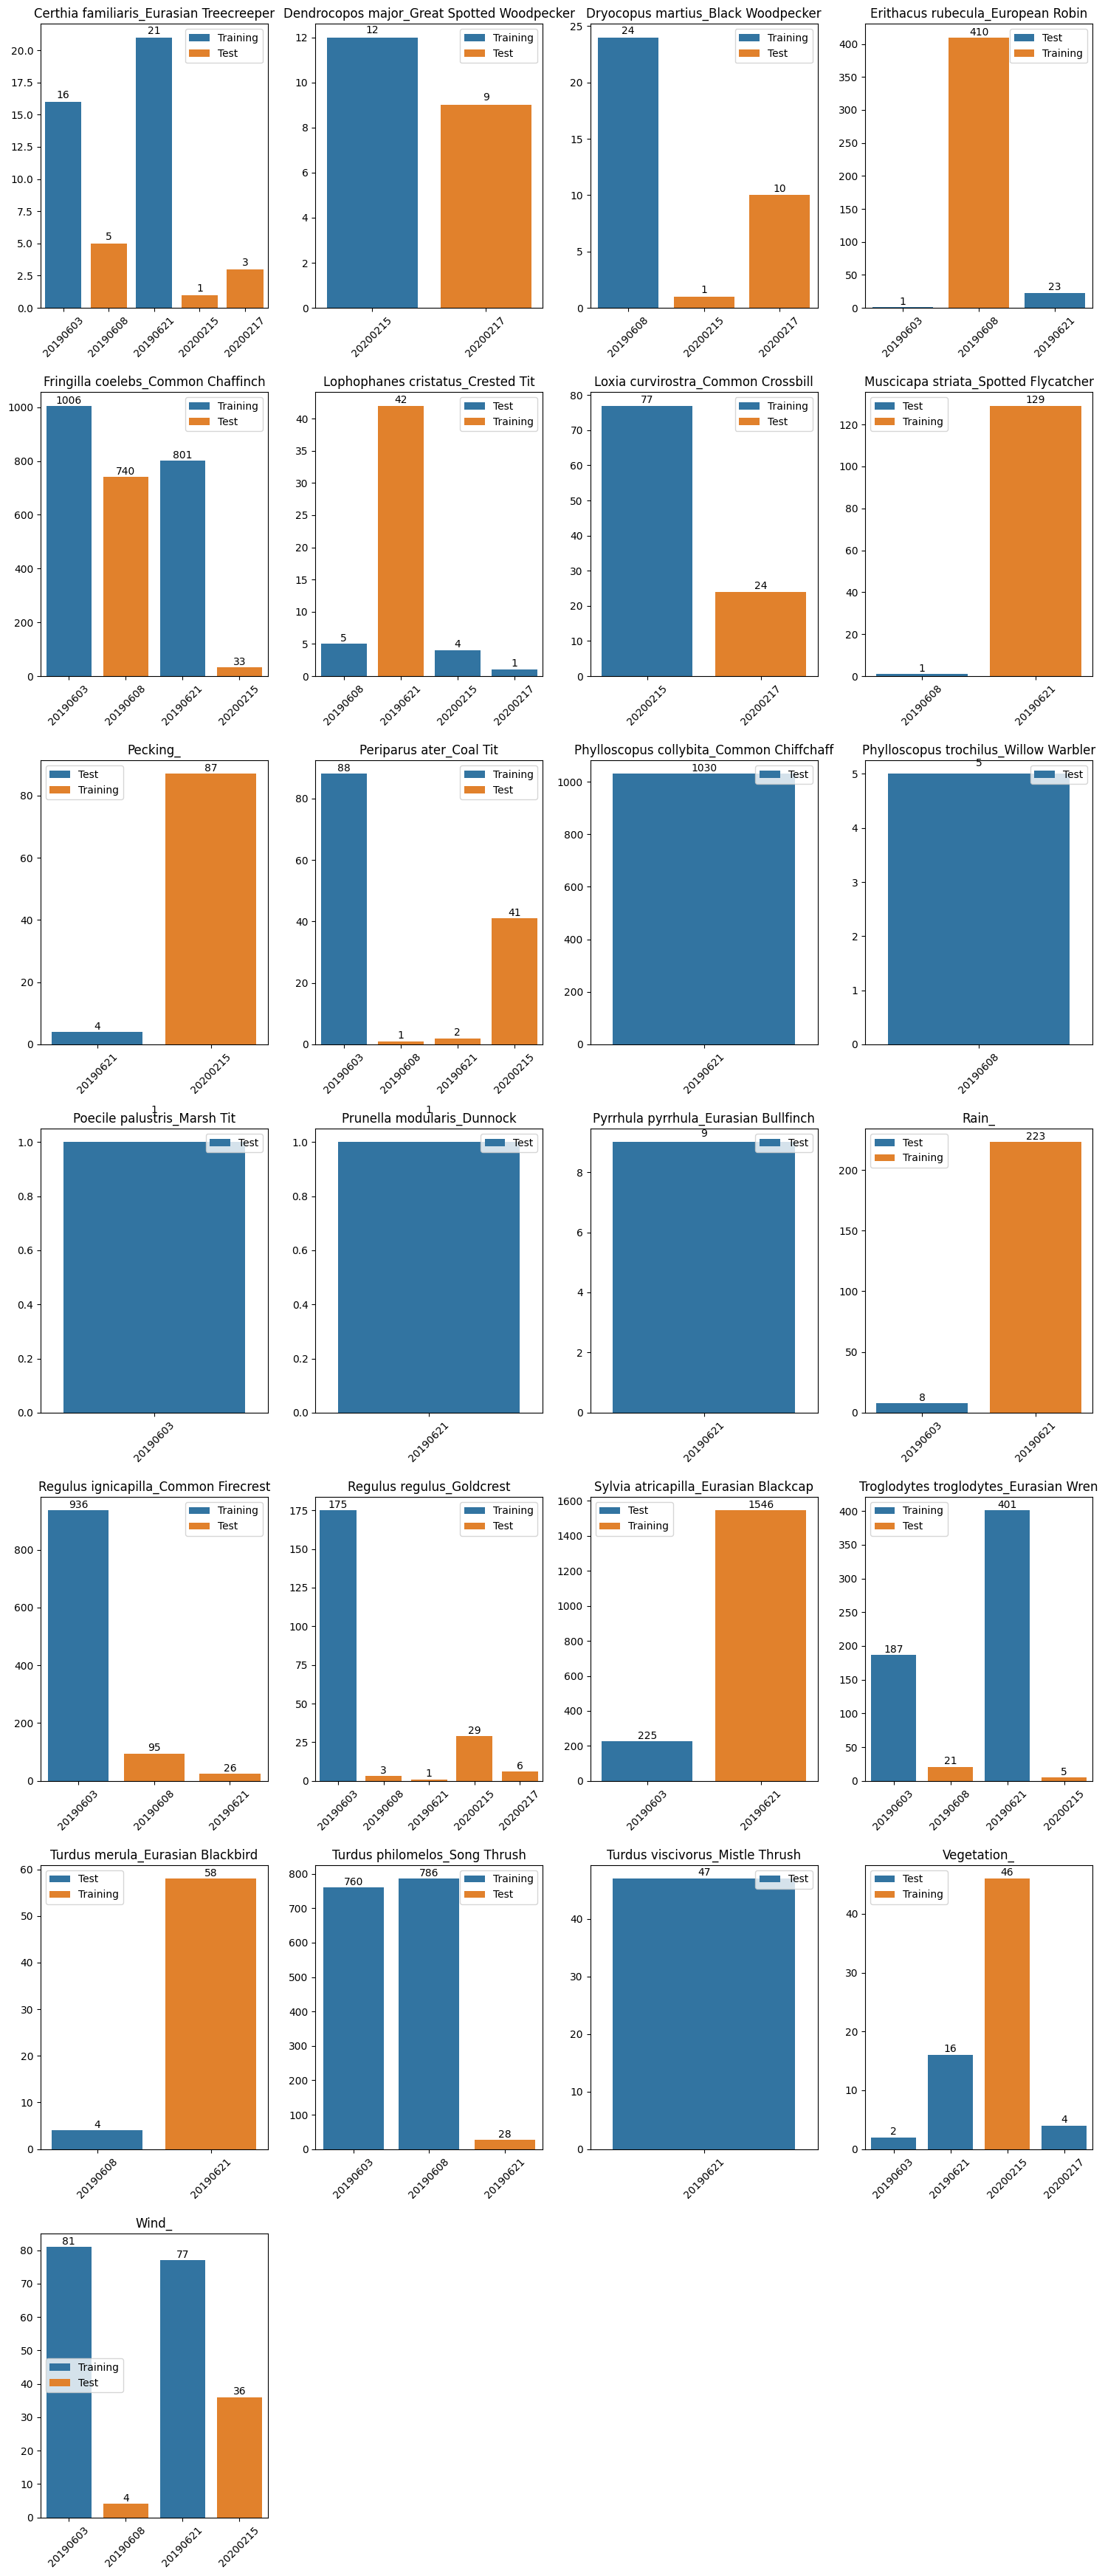

In [ ]:

# Supponiamo che 'species_date_count' contenga i tuoi dati
n_species = len(species_date_count.keys())

cols = 4
rows = (n_species // cols) + (n_species % cols != 0) 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, species in enumerate(species_date_count.keys()):
    dates = list(species_date_count[species].keys())
    counts = [ value["count"] for value in species_date_count[species].values()]
    is_training = [ "Training" if value["is_training"] else "Test" for value in species_date_count[species].values()]
    
    sns.barplot(x=dates, y=counts, ax=axes[i], hue=is_training)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.1, str(count), ha='center', va='bottom')
    axes[i].set_title(species)
    axes[i].tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse x se necessario

for i in range(n_species, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Aggiusta lo spazio tra i grafici
plt.show()


In [ ]:
source = "E:/Giacomo/Tovanella/orig_segments/train"
dest = "E:/Giacomo/Tovanella/DATASET/test"
removed = "E:/Giacomo/Tovanella/DATASET/removed"
for specie in os.listdir(source):
    # if len(species_date_count[specie]) <= 1:
    #     os.rename(
    #         os.path.join(source, specie),
    #         os.path.join(removed, specie)
    #     )
    #     continue
    os.makedirs(os.path.join(dest, specie), exist_ok=True)
    for audio in os.listdir(os.path.join(source, specie)):
        test_dates = [ date for date in species_date_count[specie].keys() 
                      if species_date_count[specie][date]["is_training"] == False ]
        audio_date = audio.split("_")[0]
        if audio_date in test_dates:
            os.rename(
                os.path.join(source, specie, audio),
                os.path.join(dest, specie, audio)
            )